# Model Evaluation (Training and Validation Loss)

In [105]:
import importlib
import tiktoken
import torch
import torch.nn as nn

In [106]:
with open("the-verdict.txt", "r", encoding = "utf-8") as f:
  rawtext = f.read()

In [107]:
tokenizer = tiktoken.get_encoding("gpt2")

In [108]:
print(rawtext[:100])
totalChars = len(rawtext)
print(totalChars)
totalTokens = len(tokenizer.encode(rawtext))
print(totalTokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
20479
5145


In [109]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}

In [110]:
'Layer Normalization'
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task

'GELU ACTIVATION FUNCTION'
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

'Feed Forward Neural Network'
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [111]:
'Masked Self Attention'
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [112]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [113]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbeddings = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.positionalEmbeddings = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbeddings = nn.Dropout(cfg["drop_rate"])

    'Transformer Block'
    self.transformerBlock = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )
    'Layer Normalization'
    self.finalNormalization = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbeddings(inIdx)
    positionalEmbeddings = self.positionalEmbeddings(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionalEmbeddings
    x = self.dropuoutEmbeddings(x)
    x = self.transformerBlock(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

In [114]:
def generateText(model, idx, maxNewTokens, contextSize):
    # idx is (batch, numTokens) array of indices in the current context
    for _ in range(maxNewTokens):
        # Crop the current context if it exceeds the supported size
        idxCond = idx[:, -contextSize:]

        # Predictions
        with torch.no_grad():
            logits = model(idxCond)  # (batch, numTokens, vocabSize)

        # S1) Extract last vector
        logits = logits[:, -1, :]  # (batch, vocabSize)

        # S2) Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)

        # S3) Choose the highest probability
        idxNext = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # S4) Append the new token to the sequence
        idx = torch.cat((idx, idxNext), dim=1)  # (batch, numTokens+1)

    return idx


In [115]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [116]:
def textToTokenId(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encodedTensor = torch.tensor(encoded).unsqueeze(0) # Adding batch dimension
  return encodedTensor
def tokenIdtoText(tokenId, tokenizer):
  flat = tokenId.squeeze(0) # Removing Batch dimension
  return tokenizer.decode(flat.tolist())

startContext = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

tokenIds = generateText(
    model = model,
    idx = textToTokenId(startContext, tokenizer),
    maxNewTokens=10,
    contextSize= GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", tokenIdtoText(tokenIds, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


* Dataset and DataLoader

In [117]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, maxLen, stride):
    self.ipIds = []
    self.targetIds = []

    # S1 --> Tokenize the Entire text
    tokenIds = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    # S2 --> Using sliding window to chunk book into overlapping sequence of maxLen
    for i in range(0, len(tokenIds) - maxLen, stride):
      inputChunk = tokenIds[i:i+maxLen]  # 0->4
      targetChunk = tokenIds[i+1:i+1+maxLen] # 1->5

      self.ipIds.append(torch.tensor(inputChunk))  # Input Tensor X
      self.targetIds.append(torch.tensor(targetChunk)) # Target Tensor Y

  def __len__(self):
    return len(self.ipIds)
  def __getitem__(self, idx):
    return self.ipIds[idx], self.targetIds[idx]  # Ip OP Pairs

In [118]:
def dataLoaderV1(txt, batch_size = 4, max_length = 256,
                 stride = 128, shuffle = True, drop_last = True,
                 num_workers = 0):
  # S1) Initialize the tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")
  # S2) Create Dataset
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  # S3) Create Dataloader
  dataloader = DataLoader(dataset, batch_size = batch_size,
                          shuffle = shuffle, drop_last = drop_last,
                          num_workers = num_workers)
  return dataloader


* Splitting Dataset

In [119]:
trainRatio = 0.90
splitIdx = int(trainRatio*len(rawtext))
trainingData = rawtext[:splitIdx]
validationData = rawtext[splitIdx:]

torch.manual_seed(123)
trainLoader = dataLoaderV1(
    trainingData,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    shuffle = True,
    drop_last = True,
    num_workers = 0
)

validationLoader = dataLoaderV1(
    validationData,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last= False,
    shuffle= False,
    num_workers= 0
)

In [120]:
'Sanity Check'
if totalTokens*(trainRatio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough data for training")
if(totalTokens*(1-trainRatio)) < GPT_CONFIG_124M["context_length"]:
  print("Not enough data for validation")

In [121]:
print("Training Loader")
for x, y in trainLoader:
  print(x.shape, y.shape)
print("Validation Loader")
for x, y in validationLoader:
  print(x.shape, y.shape)

Training Loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation Loader
torch.Size([2, 256]) torch.Size([2, 256])


In [122]:
trainingTokens = 0
for inputBatch, targetBatch in trainLoader:
  trainingTokens += inputBatch.numel()
validationTokens = 0
for inputBatch, targetBatch in validationLoader:
  validationTokens += inputBatch.numel()
print("Training Tokens: ", trainingTokens)
print("Validation Tokens: ", validationTokens)
print("Total Tokens:", totalTokens)

Training Tokens:  4608
Validation Tokens:  512
Total Tokens: 5145


* Calclating Cross Entropy Loss

In [123]:
def calculateLossBatch(inputBatch, targetBatch, model, device):
  inputBatch, targetBatch = inputBatch.to(device), targetBatch.to(device)
  logits = model(inputBatch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), targetBatch.flatten(), ignore_index = 0)
  return loss

def calculateLossLoader(dataLoaderV1, model, device, num_batches = None):
  totalLoss = 0
  if(len(dataLoaderV1) == 0): return float("nan")
  elif num_batches is None: num_batches = len(dataLoaderV1)
  else:
    # Reduce the number of batches to match the total no of batches in data loader
    num_batches = min(num_batches, len(dataLoaderV1))
  for i, (inputBatch, targetBatch) in enumerate(dataLoaderV1):
    if i< num_batches:
      loss = calculateLossBatch(inputBatch, targetBatch, model, device)
      totalLoss += loss.item()
    else : break
  return totalLoss/num_batches # Mean Loss per batch

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# NOTE: Connected to T4 GPU on COLAB thats why it is printing CUDA and execution time is less

cuda


In [125]:
model.to(device)

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [126]:
torch.manual_seed(123)
with torch.no_grad(): # Disabling gradient tracking for efficiency because we are not training yet
  trainingLoss = calculateLossLoader(trainLoader, model, device)
  validationLoss = calculateLossLoader(validationLoader, model, device)
print("Training Loss: ", trainingLoss)
print("Validation Loss: ", validationLoss)


Training Loss:  10.98753579457601
Validation Loss:  10.983574867248535


# PRETRAINING LOOP (Minimizing Loss)
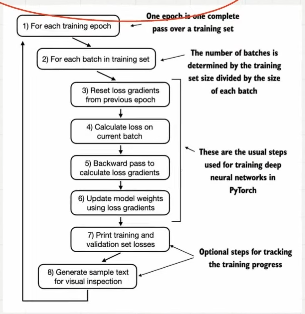

# Training LOOP


In [127]:
def trainModel(model, trainLoader, validationLoader,
               optimizer, device, numOfEpochs, evalFreq, evalIter, startContext, tokenizer):
    trainLosses, validationLosses, trackSeenTokens = [], [], []
    tokensSeen, globalStep = 0, -1

    for epoch in range(numOfEpochs):
        model.train()  # Set Model for training
        for inputBatch, targetBatch in trainLoader:
            optimizer.zero_grad()  # Clear gradients
            loss = calculateLossBatch(inputBatch, targetBatch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model parameters
            tokensSeen += inputBatch.numel()
            globalStep += 1

            # Optional eval step
            if globalStep % evalFreq == 0:
                trainingLoss, validationLoss = evaluateModel(model, trainLoader, validationLoader, evalIter)
                trainLosses.append(trainingLoss)
                validationLosses.append(validationLoss)
                trackSeenTokens.append(tokensSeen)
                print(f"Epoch {epoch+1} (Step {globalStep:06d}): Training Loss: {trainingLoss:.4f}, Validation Loss: {validationLoss:.4f}")

        print(f"Sample Generation After Epoch {epoch+1} :")
        generateAndPrintSample(model, startContext, tokenizer, device)
        print()

    return trainLosses, validationLosses, trackSeenTokens


In [128]:
def evaluateModel(model, trainLoader, validationLoader, evalIter):
  model.eval() # Set model for evaluation
  with torch.no_grad():
    trainingLoss = calculateLossLoader(trainLoader, model, device, num_batches= evalIter)
    validationLoss = calculateLossLoader(validationLoader, model, device, num_batches= evalIter)
  model.train()
  return trainingLoss, validationLoss

In [129]:
def generateAndPrintSample(model, startContext, tokenizer, device):
  model.eval()
  contextSize = model.positionalEmbeddings.weight.shape[0]
  encoded = textToTokenId(startContext, tokenizer).to(device)
  with torch.no_grad():
    tokenIds = generateText(model= model, idx = encoded, maxNewTokens=50,contextSize= contextSize, )
  decodedText = tokenIdtoText(tokenIds, tokenizer)
  print(decodedText.replace("\n", " "))
  model.train()

In [130]:
# Model Training
import time
startingTime = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
numOfEpochs = 20
trainLosses, validationLosses, tokensSeen = trainModel(
    model,
    trainLoader,
    validationLoader,
    optimizer,
    device,
    numOfEpochs=numOfEpochs,
    evalFreq= 5,
    evalIter= 5,
    startContext= "Every effort moves you",
    tokenizer = tokenizer
)
endingTime = time.time()
totalExecutionTime = (endingTime - startingTime) / 60
print(f"Training completed in {totalExecutionTime: .2f} minutes")

Epoch 1 (Step 000000): Training Loss: 9.8149, Validation Loss: 9.9248
Epoch 1 (Step 000005): Training Loss: 8.0614, Validation Loss: 8.3298
Sample Generation After Epoch 1 :
Every effort moves you,,,,,,,,,,,,.                                     

Epoch 2 (Step 000010): Training Loss: 6.6193, Validation Loss: 7.0485
Epoch 2 (Step 000015): Training Loss: 6.0444, Validation Loss: 6.6025
Sample Generation After Epoch 2 :
Every effort moves you, and,, and,,,,,,, and,.                                   

Epoch 3 (Step 000020): Training Loss: 5.5286, Validation Loss: 6.5063
Epoch 3 (Step 000025): Training Loss: 5.3884, Validation Loss: 6.3860
Sample Generation After Epoch 3 :
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and

Epoch 4 (Step 000030): Training Loss: 4.8826, Validation Loss: 6.2777
Epoch 4 (Step 000035): Training Loss: 4.6250, Validation Loss: 6.2945
Sample Generation After

* Validation Loss is much larger than raining loss this indicates model is overfitted  

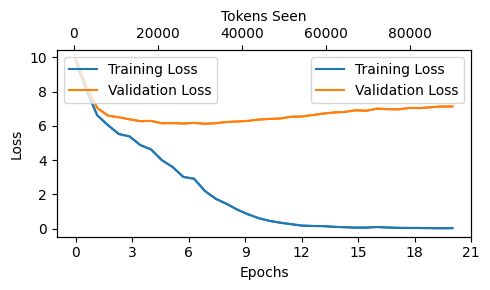

In [131]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plotLosses(epochsSeen, tokensSeen, trainLosses, validationLosses):
  fig, ax = plt.subplots(figsize=(5,3))
  ax.plot(epochsSeen, trainLosses, label="Training Loss")
  ax.plot(epochsSeen, validationLosses, label="Validation Loss")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.legend(loc = "upper right")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels


  #Second x axis for tokens seen'
  ax2 = ax.twiny() # shares same y axis
  ax2.plot(tokensSeen, trainLosses, label="Training Loss")
  ax2.plot(tokensSeen, validationLosses, label="Validation Loss")
  ax2.set_xlabel("Tokens Seen")
  ax2.legend(loc = "upper left")

  fig.tight_layout()
  plt.show()

epochsTensor = torch.linspace(0, numOfEpochs, len(trainLosses))
plotLosses(epochsTensor, tokensSeen, trainLosses, validationLosses)
